In [ ]:
import numpy as np
import pandas as pd

def normal_trapezoidal(m, suitable_min, suitable_max, optimal_min, optimal_max):
    """
    m: value in t
    """
    if np.isnan(m):
        ret = 0.25
    elif m < suitable_min:
        ret = 0 
    elif m > suitable_max:
        ret = 0
    else:
        ret = min(((m-suitable_min)/(optimal_min-suitable_min), 1, (suitable_max-m)/(suitable_max-optimal_max)))
        
    return ret

def left_trapezoidal(m, suitable_min, suitable_max, optimal_max):
    """
    m: value in t
    """
    if np.isnan(m):
        ret = 0.25
    elif m < suitable_min:
        ret = 0
    elif m > suitable_max:
        ret = 0
    else:
        ret = min((1, (suitable_max-m)/(suitable_max-optimal_max)))

    return ret

In [ ]:
temp_suitable_min = 25
temp_suitable_max = 33
temp_optimal_min = 28
temp_optimal_max = 32
do_suitable_min = 4
do_suitable_max = 10
do_optimal_min = 6
do_optimal_max = 9
ua_suitable_min = 0.00
ua_suitable_max = 0.16
ua_optimal_min = 0.00
ua_optimal_max = 0.06

def source_data(**kwargs):
    chem = pd.read_csv("data/data_chemical_v2.csv")
    bio = pd.read_csv("data/data_sample - biological.csv")

    doc = chem["Doc"].tolist()
    
    score_uia = []
    score_o2 = []
    score_temp = []

    for i in doc:
        score_uia.append(left_trapezoidal(chem[chem["Doc"] == i]["uia"].values[0],
                            kwargs["ua_suitable_min"], kwargs["ua_suitable_max"], kwargs["ua_optimal_max"]))
        
        score_o2.append(normal_trapezoidal(bio[bio["DOC"] == i]["DO_s"].values[0],
                            kwargs["do_suitable_min"], kwargs["do_suitable_max"],
                            kwargs["do_optimal_min"], kwargs["do_optimal_max"]))
        
        score_temp.append(normal_trapezoidal(bio[bio["DOC"] == i]["Suhu_s"].values[0],
                            kwargs["temp_suitable_min"], kwargs["temp_suitable_max"],
                            kwargs["temp_optimal_min"], kwargs["temp_optimal_max"]))


    f_uia = CubicSpline(doc, score_uia)
    f_o2 = CubicSpline(doc, score_o2)
    f_temp = CubicSpline(doc, score_temp)

    return f_uia, f_o2, f_temp

In [ ]:
def integrate_condition(t):
    f_uia, f_o2, f_temp = source_data(
        temp_suitable_min = 25,
        temp_suitable_max = 33,
        temp_optimal_min = 28,
        temp_optimal_max = 32,
        do_suitable_min = 4,
        do_suitable_max = 10,
        do_optimal_min = 6,
        do_optimal_max = 9,
        ua_suitable_min = 0.00,
        ua_suitable_max = 0.16,
        ua_optimal_min = 0.00,
        ua_optimal_max = 0.06
    )
    uia = f_uia(t)
    o2 = f_o2(t)
    temp = f_temp(t)
    
    return uia+o2+temp

In [ ]:
# quad(integrate_condition, 1, 2)
f_uia, f_o2, f_temp = source_data(
        temp_suitable_min = 25,
        temp_suitable_max = 33,
        temp_optimal_min = 28,
        temp_optimal_max = 32,
        do_suitable_min = 4,
        do_suitable_max = 10,
        do_optimal_min = 6,
        do_optimal_max = 9,
        ua_suitable_min = 0.00,
        ua_suitable_max = 0.16,
        ua_optimal_min = 0.00,
        ua_optimal_max = 0.06
    )

In [ ]:
class Fungsi:

    def __init__(self, a, b, f_uia, f_o2, f_temp):

        self.a = a
        self.b = b

        self.f_uia = f_uia
        self.f_o2 = f_o2
        self.f_temp = f_temp

    def _integrate_function(self, t):
        if any((self.f_temp(t) == 0, self.f_o2(t) == 0, self.f_uia(t) == 0)):
            return 0
        else:
            return self.f_temp(t) + self.f_o2(t) + self.f_uia(t)

    def get_integral(self):
        return quad(self._integrate_function, self.a, self.b, epsabs = 1e-4, limit=1000)

In [ ]:
f_uia, f_o2, f_temp = source_data(
        temp_suitable_min = 25,
        temp_suitable_max = 33,
        temp_optimal_min = 28,
        temp_optimal_max = 32,
        do_suitable_min = 4,
        do_suitable_max = 10,
        do_optimal_min = 6,
        do_optimal_max = 9,
        ua_suitable_min = 0.00,
        ua_suitable_max = 0.16,
        ua_optimal_min = 0.00,
        ua_optimal_max = 0.06
    )

# T = 120
Fungsi(1, 120, f_uia, f_o2, f_temp).get_integral()[0]

In [ ]:
from lib.helpers import heaviside_step
class PartialHarvest:
    def __init__(self, t0, t, wn, w0, alpha, n0: int, sr: float, m: float, 
        ph: list, doc: list, final_doc:int = 120,):
        self.t0 = t0
        self.t = t
        self.wn = wn
        self.w0 = w0
        self.alpha = alpha
        self.n0 = n0
        self.sr = sr
        self.m = m
        self.ph = ph
        self.doc = doc
        self.final_doc = final_doc

        # self.biomassa_n_1 = biomass_n_1
        # self.area = area


    def _fr(self, temp_suitable_min = 25,
        temp_suitable_max = 33,
        temp_optimal_min = 28,
        temp_optimal_max = 32,
        do_suitable_min = 4,
        do_suitable_max = 10,
        do_optimal_min = 6,
        do_optimal_max = 9,
        ua_suitable_min = 0.00,
        ua_suitable_max = 0.16,
        ua_optimal_min = 0.00,
        ua_optimal_max = 0.06):
        return Fungsi(self.t0, self.t).get_integral()[0]

    def wt(self):
        return (self.wn**(1/3) - (self.wn**(1/3) - self.w0**(1/3)) * np.exp(-self.alpha * self._fr()))**3

    def population(self):
        partial_harvest = []
        for i, j in enumerate(self.doc):
            partial_harvest.append(self.ph[i] * heaviside_step(self.t - j))

        if self.t >= self.final_doc:           
            partial_harvest.append((self.sr - sum(self.ph)) * heaviside_step(self.t - self.final_doc))
        
        result = self.n0 * (np.exp(-self.m * self.t) - sum(partial_harvest))
        return result


    def biomassa(self):
        # biomassa in gram
        result = self.wt() * self.population()
        return result



In [ ]:
from test import source_data as sd
f_uia, f_o2, f_temp, score_csc = sd(
        temp_suitable_min = 25,
        temp_suitable_max = 33,
        temp_optimal_min = 28,
        temp_optimal_max = 32,
        do_suitable_min = 4,
        do_suitable_max = 10,
        do_optimal_min = 6,
        do_optimal_max = 9,
        ua_suitable_min = 0.00,
        ua_suitable_max = 0.16,
        ua_optimal_min = 0.00,
        ua_optimal_max = 0.06,
        csc_suitable_min = 0.00,
        csc_suitable_max = 0.5,
        csc_optimal_min = 0.00,
        csc_optimal_max = 5
    )

In [ ]:
from biomass import baseBiomass

obj = baseBiomass(0, 60, 75, 0.05, 0.0013, 3400, 0.98, 0.002, [0.1, 0.1, 0.1], [60, 70, 80], f_uia, f_o2, f_temp, score_csc)
obj.biomassa()

In [1]:
from partial_harvest import PartialHarvest
from biomass import source_data, baseBiomass, left_trapezoidal
from lib.helpers import price_function

def score_csc_compute(biomass, volume,
        csc_suitable_min = 0.00,
        csc_suitable_max = 0.5,
        csc_optimal_max = 5):
    
    return left_trapezoidal(biomass/volume, csc_suitable_min, csc_suitable_max, csc_optimal_max)

f_uia, f_o2, f_temp = source_data(
    temp_suitable_min = 25,
    temp_suitable_max = 33,
    temp_optimal_min = 28,
    temp_optimal_max = 32,
    do_suitable_min = 4,
    do_suitable_max = 10,
    do_optimal_min = 6,
    do_optimal_max = 9,
    ua_suitable_min = 0.00,
    ua_suitable_max = 0.16,
    ua_optimal_min = 0.00,
    ua_optimal_max = 0.06,
)


csc_suitable_min = 0.00
csc_suitable_max = 0.5
csc_optimal_min = 0.00
csc_optimal_max = 5

# score_csc = score_csc_compute(0, 1000, csc_suitable_min, csc_suitable_max, csc_optimal_max)


In [2]:
T = 82

weight = []
biomassa = []
revenue = []
f = price_function("data/fixed_price.csv")
for i in range(T):
    if i == 0:
        score_csc = score_csc_compute(0, 1000, csc_suitable_min, csc_suitable_max, csc_optimal_max)
        obj = baseBiomass(0, i, 75, 0.05, 0.0013, 3400, 0.98, 0.002, [0.1, 0.1, 0.1], [60, 70, 80], f_uia, f_o2, f_temp, score_csc, 120)
        ph = PartialHarvest(0, i, [60, 70, 80], obj.wt(), obj.population(), obj.biomassa(), 0, 120)
    else:
        score_csc = score_csc_compute(biomassa[-1], 1000, csc_suitable_min, csc_suitable_max, csc_optimal_max)
        obj = baseBiomass(0, i, 75, 0.05, 0.0013, 3400, 0.98, 0.002, [0.1, 0.1, 0.1], [60, 70, 80], f_uia, f_o2, f_temp, score_csc, 120)
        ph = PartialHarvest(0, i, [60, 70, 80], obj.wt(), obj.population(), obj.biomassa(), biomassa[-1], 120)
    
    weight.append(obj.wt())
    biomassa.append(obj.biomassa())
    revenue.append(ph.realized_revenue(f))
    
    
    

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3655.7715344467233
0
0
0
0
0
0
0
0
0
3906.7720017767188
0
0
0
0
0
0
0
0
0
3995.0834710786876
0


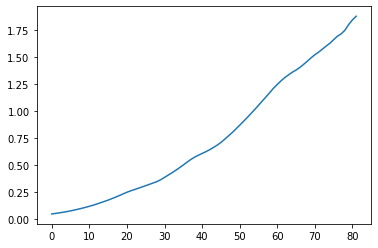

In [4]:
import matplotlib.pyplot as plt

x = list(range(T))
plt.plot(x, weight)

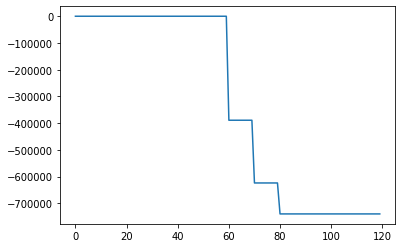

In [5]:
import numpy as np
cum_revenue = np.cumsum(revenue)
plt.plot(x, cum_revenue)

In [5]:
weight[60]

1.2451120011561025